In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
device = 'cpu'

In [3]:
batch_size = 100

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
indices = [idx for idx, target in enumerate(trainset.targets) if target in [0]]
trainsetclass0 = torch.utils.data.Subset(trainset, indices)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=True, num_workers=2)

l_train = len(trainsetclass0)

validationsetclass0, trainsetclass0 = random_split(trainsetclass0, [int(l_train*0.2), int(l_train*0.8)])

trainloader = torch.utils.data.DataLoader(trainsetclass0, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationsetclass0, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


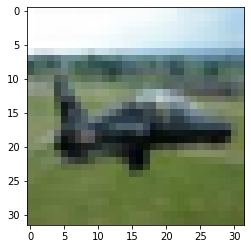

In [4]:
#sample training image
plt.imshow(np.transpose(trainsetclass0[0][0], (1, 2, 0))) 

## __Convolutional Autoencoder__

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),    
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  
            nn.ReLU(),
		      	nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),  
            nn.ReLU(),
            )
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),)

    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [ ]:
# Train Neural Network
import tqdm
torch.manual_seed(123)
num_epochs = [25]
lr_list = [0.1,0.01, 0.001]
wd_list = [0.01, 0.001, 0.0001]
criterion  = nn.MSELoss()

for lr in lr_list:
  for weight_decay in wd_list:
    for epochs in num_epochs:

      ConvAE_model = ConvAutoEncoder()
      save_training_loss = []
      save_validation_loss = []
      
      tqdm_epoch = tqdm.trange(epochs)
      for epoch in tqdm_epoch:
            optConvAE = optim.Adam(ConvAE_model.parameters(), lr= lr, weight_decay= weight_decay)
            training_loss_ConvAE = 0 
            
            # Training Set
            for batch_ind, (image,_) in enumerate(trainloader):
                
                #image = image.to(device)
                
                # ConvAE model
                optConvAE.zero_grad()
                out_ConvAE = ConvAE_model(image)
                loss_ConvAE = criterion(image, out_ConvAE)
                loss_ConvAE.backward()
                optConvAE.step()
                training_loss_ConvAE += loss_ConvAE.item()

            # Save Training Loss    
            save_training_loss.append(training_loss_ConvAE)
            validation_loss_ConvAE = 0.0  

            # Validation Set
            for batch_ind, (image,_) in enumerate(validationloader):

                # ConvAE model
                out_ConvAE = ConvAE_model(image)
                loss_ConvAE = criterion(image, out_ConvAE)
                validation_loss_ConvAE += loss_ConvAE.item()
     
            save_validation_loss.append(validation_loss_ConvAE)
      average_training_loss = np.mean(save_training_loss)
      average_validation_loss = np.mean(save_validation_loss)
      print(f"Learning Rate: {lr}")
      print(f"Weight Decay: {weight_decay}")
      print(f"Number of Epochs: {epochs}")
      print(f"Avg. Training Loss: {average_training_loss}")   
      print(f"Avg. Validation Loss: {average_validation_loss}") 
      PATH = './anomaly_model_'+str(lr)+'_'+str(weight_decay)+'_'+str(epochs)+'_'+'.pth'
      torch.save(ConvAE_model, PATH)
      print('\n')            

100%|██████████| 25/25 [01:59<00:00,  4.79s/it]


Learning Rate: 0.1
Weight Decay: 0.01
Number of Epochs: 25
Avg. Training Loss: 3.1354088872671126
Avg. Validation Loss: 0.6447609435021877




100%|██████████| 25/25 [02:09<00:00,  5.18s/it]


Learning Rate: 0.1
Weight Decay: 0.001
Number of Epochs: 25
Avg. Training Loss: 4.308563438951969
Avg. Validation Loss: 0.6676524080336094




100%|██████████| 25/25 [02:24<00:00,  5.76s/it]


Learning Rate: 0.1
Weight Decay: 0.0001
Number of Epochs: 25
Avg. Training Loss: 8.542020353376865
Avg. Validation Loss: 2.1116907581686974




100%|██████████| 25/25 [01:57<00:00,  4.72s/it]


Learning Rate: 0.01
Weight Decay: 0.01
Number of Epochs: 25
Avg. Training Loss: 2.5557162277400494
Avg. Validation Loss: 0.6442295542359352




100%|██████████| 25/25 [01:59<00:00,  4.78s/it]


Learning Rate: 0.01
Weight Decay: 0.001
Number of Epochs: 25
Avg. Training Loss: 2.549959695637226
Avg. Validation Loss: 0.6425172163546086




100%|██████████| 25/25 [01:59<00:00,  4.78s/it]


Learning Rate: 0.01
Weight Decay: 0.0001
Number of Epochs: 25
Avg. Training Loss: 1.703316987901926
Avg. Validation Loss: 0.32611277550458906




100%|██████████| 25/25 [02:00<00:00,  4.83s/it]


Learning Rate: 0.001
Weight Decay: 0.01
Number of Epochs: 25
Avg. Training Loss: 2.5695716789364815
Avg. Validation Loss: 0.6477271854877472




100%|██████████| 25/25 [01:58<00:00,  4.73s/it]


Learning Rate: 0.001
Weight Decay: 0.001
Number of Epochs: 25
Avg. Training Loss: 2.5568622288107874
Avg. Validation Loss: 0.6437994840741158




100%|██████████| 25/25 [01:58<00:00,  4.74s/it]

Learning Rate: 0.001
Weight Decay: 0.0001
Number of Epochs: 25
Avg. Training Loss: 1.2850014992803336
Avg. Validation Loss: 0.28949382826685904




In [11]:
# Neural Network with optimal parameters
PATH_optimal_model = './anomaly_model_'+str(0.001)+'_'+str(0.0001)+'_'+str(1)+'_'+'.pth'
optConvAE = torch.load(PATH)


In [12]:
# Define a function to plot both training and validation loss
def plot_loss(training_loss, validation_loss):
    fig = plt.figure(figsize=(12,8)) 
    plt.plot(training_loss, color = "red", linewidth=3, label = 'Training Loss')
    plt.plot(validation_loss, color = "green", linewidth=3, label = 'Validation Loss')
    plt.xlabel("Epoch Number", fontsize = 12)
    plt.ylabel("Loss", fontsize = 14) 
    plt.title("Neural Network Loss by Epoch", fontsize = 16, fontweight = "bold")
    #plt.xticks(np.arange(0, 22, 2))
    plt.legend(fontsize = 12)
    plt.grid()
    plt.show()

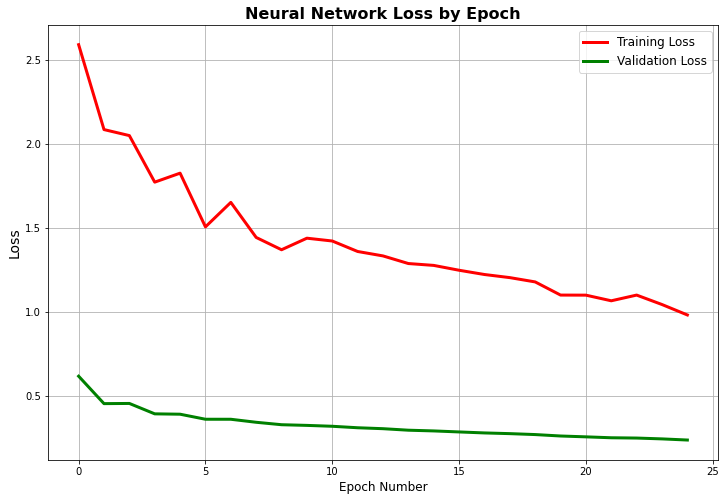

In [13]:
plot_loss(save_training_loss, save_validation_loss)

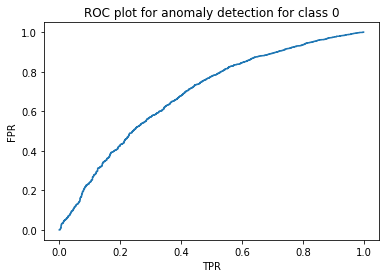

The AUC is  0.3127082222222222


In [14]:
for batch_ind, (image,target) in enumerate(testloader):
    ConvAE_model.eval()
    with torch.no_grad():
        reconstructed_image = ConvAE_model(image)
test_mse = torch.mean((image.view(10000,-1)-reconstructed_image.view(10000,-1))**2,dim=1)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target, test_mse, pos_label=0)
plt.plot(tpr,fpr)
plt.title("ROC plot for anomaly detection for class 0")
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.show()
print("The AUC is ",metrics.auc(fpr, tpr))


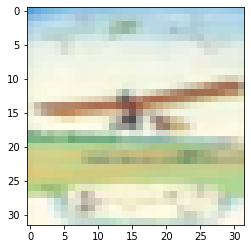

In [57]:
plt.imshow(np.transpose(image[0:2][1], (1, 2, 0))) 

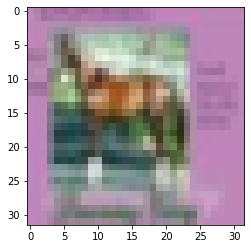

In [58]:
plt.imshow(np.transpose(image[0:2][0], (1, 2, 0))) 

In [38]:
diff_image = torch.abs(image[0:2]-reconstructed_image[0:2])

In [39]:
target[0:2]

tensor([7, 0])

In [40]:
diff_image.size()

torch.Size([2, 3, 32, 32])

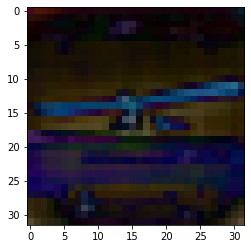

In [41]:
plt.imshow(np.transpose(diff_image[1], (1, 2, 0))) 

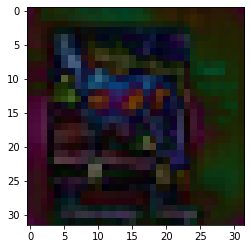

In [43]:
plt.imshow(np.transpose(diff_image[0], (1, 2, 0))) 


In [45]:
diff_image = torch.mean(torch.abs(image[0:2]-reconstructed_image[0:2]),dim=1,keepdim=True)

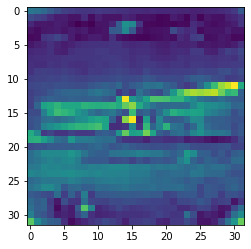

In [52]:
plt.imshow(torch.reshape(diff_image[1], (32,32))) 

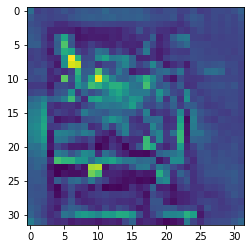

In [53]:
plt.imshow(torch.reshape(diff_image[0], (32,32))) 